Data Preprocessing

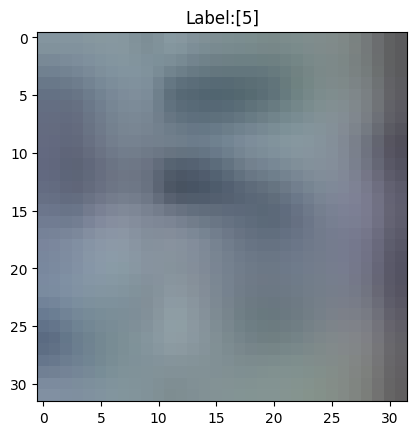

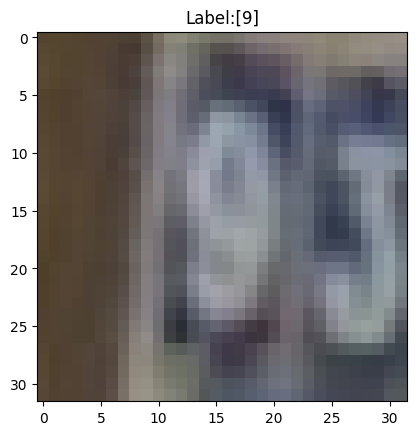

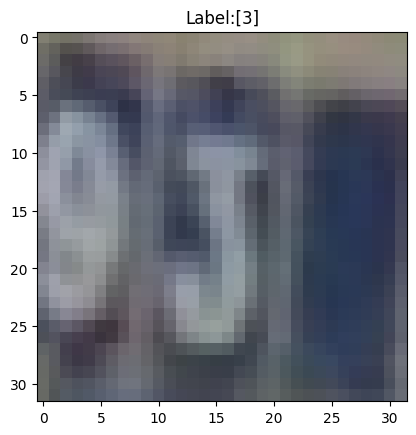

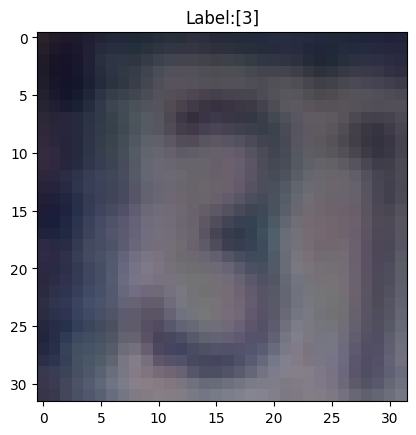

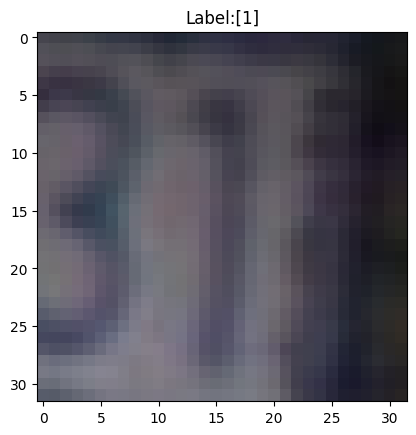

In [ ]:
import numpy as np
import pandas as pd
import scipy.io as sio
!pip install opencv-python
import cv2 as c

train_dat = sio.loadmat("train_32x32.mat")
test_dat = sio.loadmat("test_32x32.mat")

train_feat, train_lab = train_dat['X'], train_dat['y']
test_feat, test_lab = test_dat['X'], test_dat['y']

train_feat = np.transpose(train_feat, (3,0,1,2))
train_feat = train_feat[:5000,:,:,:]
test_feat = np.transpose(test_feat, (3,0,1,2))
test_feat = test_feat[:5000,:,:,:]

train_lab[train_lab == 10] = 0
test_lab[test_lab == 10] = 0
train_lab = train_lab[:5000]
test_lab = test_lab[:5000]

import matplotlib.pyplot as plt


for i in (range(5,10)):
    plt.imshow(train_feat[i])
    plt.title(f"Label:{train_lab[i]}")
    plt.show()



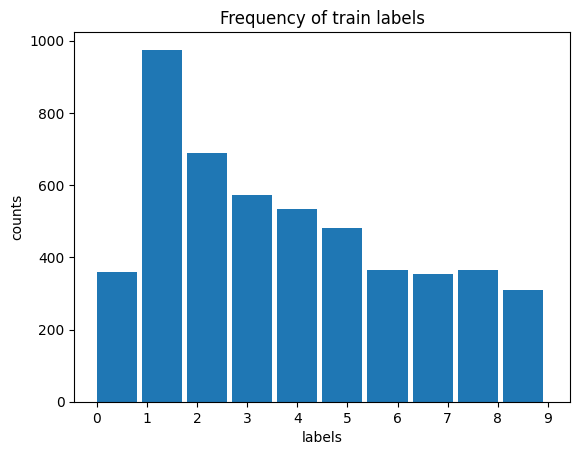

In [ ]:

plt.hist(train_lab, width= 0.8)
plt.xlabel('labels')
plt.ylabel('counts')
plt.title('Frequency of train labels')
plt.xticks(np.unique(train_lab))

plt.show()

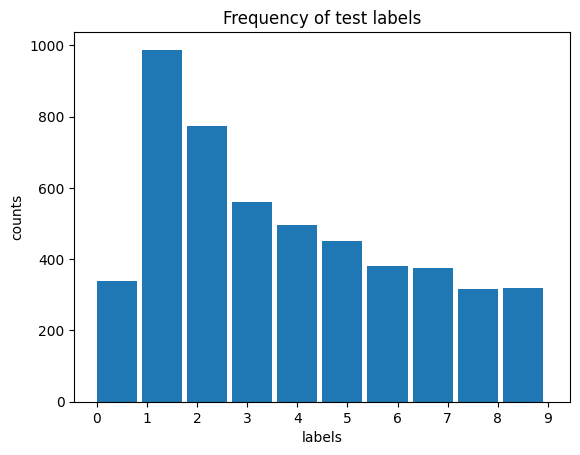

In [ ]:
plt.hist(test_lab, width = 0.8)
plt.xlabel('labels')
plt.ylabel('counts')
plt.title('Frequency of test labels')
plt.xticks(np.unique(test_lab))

plt.show()

In [ ]:

!pip install imbalanced-learn

from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

orig_shape = train_feat.shape
train_feat_flat = train_feat.reshape(orig_shape[0], -1) #Retaining only the number of images and combining the other elements

#hybrid sampling
train_lab = np.array(train_lab).flatten()
class_counts = Counter(train_lab)

#oversampling
max_class_count = max(class_counts.values())
oversampling_strategy = {label: max_class_count for label in class_counts}

min_class_count = min(class_counts.values())
undersampling_strategy = {label:min_class_count for label in class_counts}

oversample = RandomOverSampler(sampling_strategy=oversampling_strategy, random_state=42)
undersample = RandomUnderSampler(sampling_strategy=undersampling_strategy, random_state=42)

train_feat_os, train_lab_os = oversample.fit_resample(train_feat_flat, train_lab)
train_feat_resample, train_lab_resample = undersample.fit_resample (train_feat_os, train_lab_os)

#reshape back to original format
train_feat_resample = train_feat_resample.reshape(-1, *orig_shape[1:])


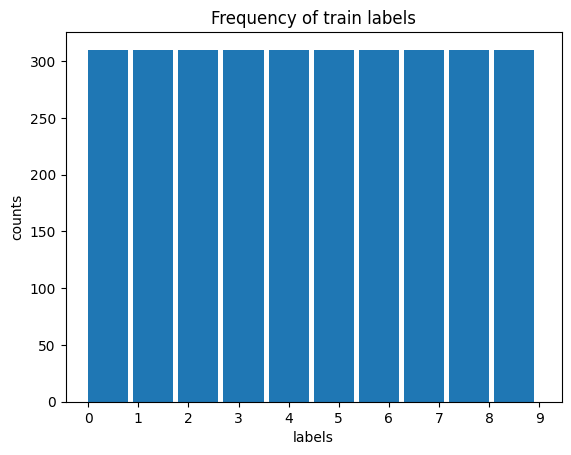

In [ ]:
plt.hist(train_lab_resample, width= 0.8)
plt.xlabel('labels')
plt.ylabel('counts')
plt.title('Frequency of train labels')
plt.xticks(np.unique(train_lab))
plt.show()

In [ ]:
orig_shape = test_feat.shape
test_feat_flat = test_feat.reshape(orig_shape[0], -1) #flatten images

test_lab = np.array(test_lab).flatten()
class_counts = Counter(test_lab)

#oversampling
max_class_count = max(class_counts.values())
oversampling_strategy = {label: max_class_count for label in class_counts}

min_class_count = min(class_counts.values())
undersampling_strategy = {label:min_class_count for label in class_counts}

oversample = RandomOverSampler(sampling_strategy=oversampling_strategy, random_state=42)
undersample = RandomUnderSampler(sampling_strategy=undersampling_strategy, random_state=42)

test_feat_os, test_lab_os = oversample.fit_resample(test_feat_flat, test_lab)
test_feat_resample, test_lab_resample = undersample.fit_resample (test_feat_os, test_lab_os)

#reshape back to original format
test_feat_resample = test_feat_resample.reshape(-1, *orig_shape[1:])

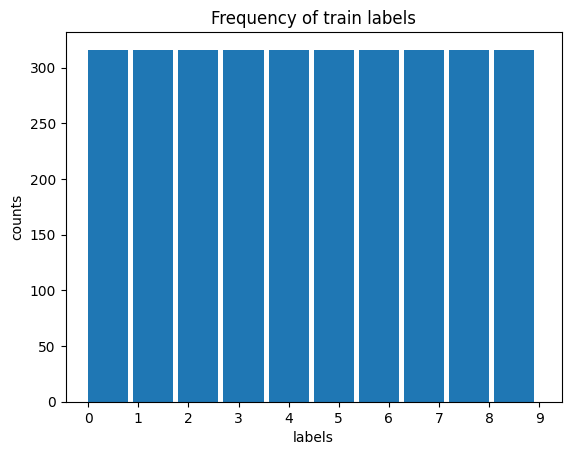

In [ ]:
plt.hist(test_lab_resample, width= 0.8)
plt.xlabel('labels')
plt.ylabel('counts')
plt.title('Frequency of train labels')
plt.xticks(np.unique(train_lab))

plt.show()

In [ ]:
#application of grey scaling

train_feat_g = []

for image in train_feat_resample:
    im = c.cvtColor(image, c.COLOR_BGR2GRAY)
    im = c.medianBlur(im,3)
    im = c.adaptiveThreshold(im,255, c.ADAPTIVE_THRESH_GAUSSIAN_C, c.THRESH_BINARY, 11, 2)
    train_feat_g.append(im)



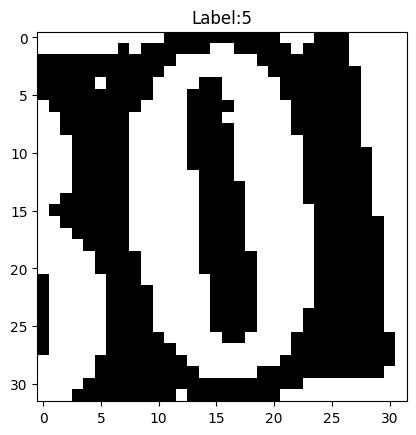

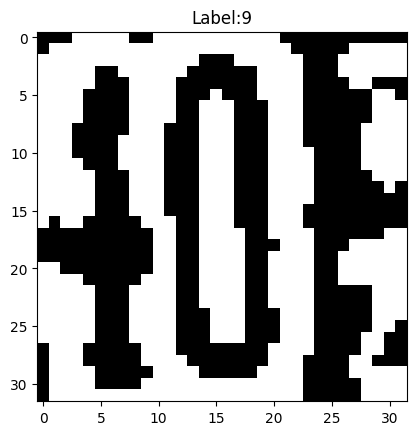

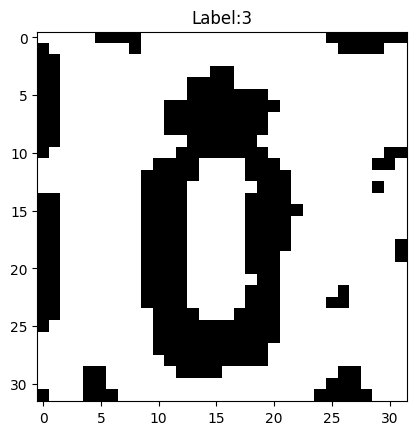

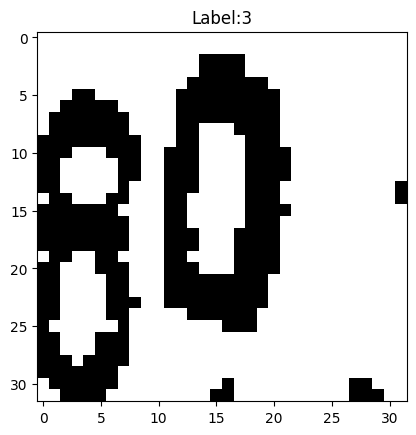

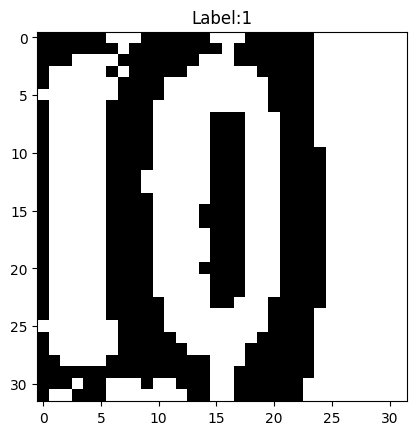

In [ ]:
for i in (range(5,10)):
    plt.imshow(train_feat_g[i], cmap = 'gray')
    plt.title(f"Label:{train_lab[i]}")
    plt.show()

In [ ]:
test_feat_g = []

for image in test_feat_resample:
    im = c.cvtColor(image, c.COLOR_BGR2GRAY)
    im = c.medianBlur(im,3)
    im = c.adaptiveThreshold(im,255, c.ADAPTIVE_THRESH_GAUSSIAN_C, c.THRESH_BINARY, 11, 2)
    test_feat_g.append(im)

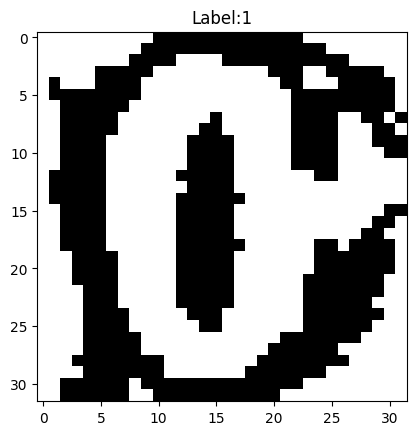

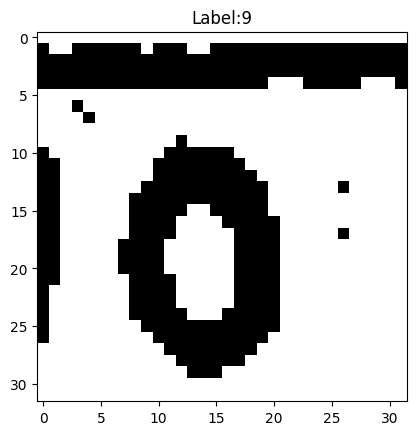

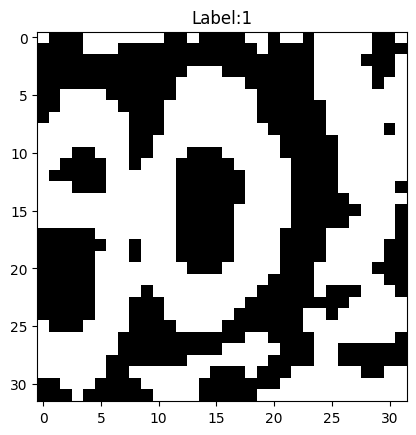

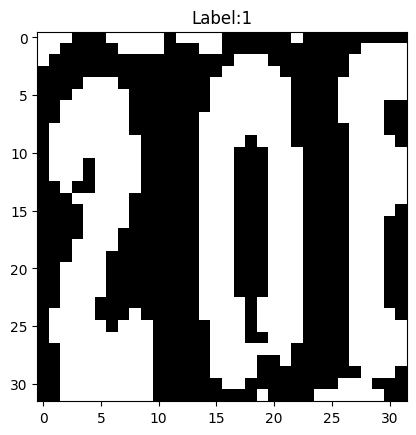

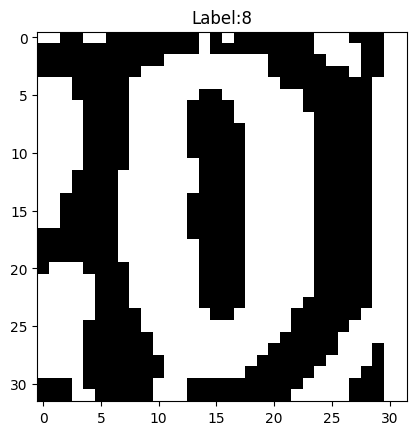

In [ ]:
for i in (range(5,10)):
    plt.imshow(test_feat_g[i], cmap = 'gray')
    plt.title(f"Label:{test_lab[i]}")
    plt.show()

In [ ]:
#flattening and standardising data
flat_train_feat = train_feat_resample.reshape(train_feat_resample.shape[0],-1)
flat_test_feat = test_feat_resample.reshape(test_feat_resample.shape[0],-1)



Logistic Regression

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components = 0.95),LogisticRegression(max_iter=500))
pipe.fit(flat_train_feat, train_lab_resample)



Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('logisticregression', LogisticRegression(max_iter=500))])

In [ ]:
predictions = pipe.predict(flat_test_feat)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(predictions, test_lab_resample)
report = classification_report(test_lab_resample,predictions,output_dict = True)
report = pd.DataFrame(report)
report = report.rename(columns = {'macro avg':'Macro Average for Logistic Regression'})

print('accuracy:',accuracy)
print('report:',report)

accuracy: 0.1620253164556962
report:                     0           1           2           3           4  \
precision    0.166163    0.178322    0.135922    0.078341    0.232143   
recall       0.174051    0.161392    0.132911    0.053797    0.205696   
f1-score     0.170015    0.169435    0.134400    0.063790    0.218121   
support    316.000000  316.000000  316.000000  316.000000  316.000000   

                    5           6           7           8           9  \
precision    0.113565    0.178723    0.156915    0.149718    0.202198   
recall       0.113924    0.132911    0.186709    0.167722    0.291139   
f1-score     0.113744    0.152450    0.170520    0.158209    0.238651   
support    316.000000  316.000000  316.000000  316.000000  316.000000   

           accuracy  Macro Average for Logistic Regression  weighted avg  
precision  0.162025                               0.159201      0.159201  
recall     0.162025                               0.162025      0.162025  
f1-sco

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings

param_grid = {
    'C':[0.1,1,10],
    'penalty':['elasticnet'],
    'solver':['saga'],
    'l1_ratio':[0.5,0.75,1.0],
    'max_iter':[500]
}

pipe_ = make_pipeline(StandardScaler(), PCA(n_components = 0.95), GridSearchCV(LogisticRegression(), param_grid, cv = 3, scoring = 'accuracy'))


In [ ]:
pipe_.fit(flat_train_feat, train_lab_resample)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('gridsearchcv',
                 GridSearchCV(cv=3, estimator=LogisticRegression(),
                              param_grid={'C': [0.1, 1, 10],
                                          'l1_ratio': [0.5, 0.75, 1.0],
                                          'max_iter': [500],
                                          'penalty': ['elasticnet'],
                                          'solver': ['saga']},
                              scoring='accuracy'))])

In [ ]:
grid_search_ = pipe_.named_steps['gridsearchcv']

results_=grid_search_.cv_results_

results = pd.DataFrame(results_)
results = results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
results.sort_values(by = 'rank_test_score')

,params,mean_test_score,std_test_score,rank_test_score
2,"{'C': 0.1, 'l1_ratio': 1.0, 'max_iter': 500, '...",0.190005,0.012070,1
1,"{'C': 0.1, 'l1_ratio': 0.75, 'max_iter': 500, ...",0.189682,0.009194,2
4,"{'C': 1, 'l1_ratio': 0.75, 'max_iter': 500, 'p...",0.189679,0.005585,3
5,"{'C': 1, 'l1_ratio': 1.0, 'max_iter': 500, 'pe...",0.189357,0.007404,4
6,"{'C': 10, 'l1_ratio': 0.5, 'max_iter': 500, 'p...",0.189357,0.006409,4
7,"{'C': 10, 'l1_ratio': 0.75, 'max_iter': 500, '...",0.189357,0.006409,4
8,"{'C': 10, 'l1_ratio': 1.0, 'max_iter': 500, 'p...",0.189357,0.006409,4
3,"{'C': 1, 'l1_ratio': 0.5, 'max_iter': 500, 'pe...",0.189357,0.006100,8
0,"{'C': 0.1, 'l1_ratio': 0.5, 'max_iter': 500, '...",0.187422,0.007247,9


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['mean_test_score'].plot(kind='hist', bins=20, title='mean_test_score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['std_test_score'].plot(kind='hist', bins=20, title='std_test_score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['rank_test_score'].plot(kind='hist', bins=20, title='rank_test_score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='mean_test_score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='mean_test_score', y='std_test_score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='std_test_score', y='rank_test_score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['rank_test_score']
  ys = series['index']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('rank_test_score', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('rank_test_score')
_ = plt.ylabel('index')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['rank_test_score']
  ys = series['mean_test_score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('rank_test_score', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('rank_test_score')
_ = plt.ylabel('mean_test_score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['rank_test_score']
  ys = series['std_test_score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('rank_test_score', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('rank_test_score')
_ = plt.ylabel('std_test_score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['rank_test_score']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'rank_test_score'}, axis=1)
              .sort_values('rank_test_score', ascending=True))
  xs = counted['rank_test_score']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('rank_test_score', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('rank_test_score')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_11['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['mean_test_score'].plot(kind='line', figsize=(8, 4), title='mean_test_score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['std_test_score'].plot(kind='line', figsize=(8, 4), title='std_test_score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['rank_test_score'].plot(kind='line', figsize=(8, 4), title='rank_test_score')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
from sklearn.linear_model import LogisticRegression
#using the best parameters
pipe_final = make_pipeline(StandardScaler(), PCA(n_components = 0.95), LogisticRegression(C=0.1, l1_ratio=1.0, max_iter=500, penalty='elasticnet',
                   solver='saga'))
pipe_final.fit(flat_train_feat, train_lab_resample)
predictions_final = pipe_final.predict(flat_test_feat)

accuracy_final = accuracy_score(predictions_final, test_lab_resample)
report_final = classification_report(test_lab_resample,predictions_final,output_dict = True)
report_final = pd.DataFrame(report_final)
report_final = report_final.rename(columns = {'macro avg':'Macro Average for Logistic Regression'})



In [ ]:
accuracy_final

0.16677215189873418

In [ ]:

report_final

,0,1,2,3,4,5,6,7,8,9,accuracy,Macro Average for Logistic Regression,weighted avg
precision,0.170279,0.196364,0.145270,0.096618,0.238596,0.100649,0.196078,0.158038,0.147632,0.195876,0.166772,0.164540,0.164540
recall,0.174051,0.170886,0.136076,0.063291,0.215190,0.098101,0.158228,0.183544,0.167722,0.300633,0.166772,0.166772,0.166772
f1-score,0.172144,0.182741,0.140523,0.076482,0.226290,0.099359,0.175131,0.169839,0.157037,0.237203,0.166772,0.163675,0.163675
support,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,0.166772,3160.000000,3160.000000


Decision Tree

In [ ]:
from sklearn import tree

pipe2 = make_pipeline(StandardScaler(), PCA(n_components = 0.95),tree.DecisionTreeClassifier())
pipe2.fit(flat_train_feat, train_lab_resample)
predictions2=pipe.predict(flat_test_feat)



In [ ]:
accuracy2 = accuracy_score(predictions2, test_lab_resample)
report2 = classification_report(test_lab_resample,predictions2, output_dict = True)
report2 = pd.DataFrame(report2)
report2 = report2.rename(columns = {'macro avg':'Macro Average for Decision Tree'})
print('accuracy:',accuracy2)
print('report:',report2)

accuracy: 0.1620253164556962
report:                     0           1           2           3           4  \
precision    0.166163    0.178322    0.135922    0.078341    0.232143   
recall       0.174051    0.161392    0.132911    0.053797    0.205696   
f1-score     0.170015    0.169435    0.134400    0.063790    0.218121   
support    316.000000  316.000000  316.000000  316.000000  316.000000   

                    5           6           7           8           9  \
precision    0.113565    0.178723    0.156915    0.149718    0.202198   
recall       0.113924    0.132911    0.186709    0.167722    0.291139   
f1-score     0.113744    0.152450    0.170520    0.158209    0.238651   
support    316.000000  316.000000  316.000000  316.000000  316.000000   

           accuracy  Macro Average for Decision Tree  weighted avg  
precision  0.162025                         0.159201      0.159201  
recall     0.162025                         0.162025      0.162025  
f1-score   0.162025     

In [ ]:
param_grid1 = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', None]
}

pipe2_ = make_pipeline(StandardScaler(), PCA(n_components = 0.95), GridSearchCV(tree.DecisionTreeClassifier(), param_grid1, cv = 3, scoring = 'accuracy'))

pipe2_.fit(flat_train_feat, train_lab_resample)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('gridsearchcv',
                 GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
                              param_grid={'criterion': ['gini', 'entropy'],
                                          'max_depth': [3, 5, 10, None],
                                          'max_features': ['sqrt', 'log2',
                                                           None],
                                          'min_samples_leaf': [1, 2, 5],
                                          'min_samples_split': [2, 5, 10]},
                              scoring='accuracy'))])

In [ ]:
grid_search2_ = pipe2_.named_steps['gridsearchcv']

results2_=grid_search2_.cv_results_

results2 = pd.DataFrame(results2_)
results2 = results2[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
results2.sort_values(by = 'rank_test_score')

,params,mean_test_score,std_test_score,rank_test_score
207,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.439355,0.011068,1
99,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.437106,0.032753,2
198,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.414197,0.014469,3
90,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.412903,0.003557,4
189,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.409036,0.012974,5
...,...,...,...,...
114,"{'criterion': 'entropy', 'max_depth': 3, 'max_...",0.119680,0.007828,212
3,"{'criterion': 'gini', 'max_depth': 3, 'max_fea...",0.117745,0.008346,213
14,"{'criterion': 'gini', 'max_depth': 3, 'max_fea...",0.117419,0.005062,214
6,"{'criterion': 'gini', 'max_depth': 3, 'max_fea...",0.116127,0.011674,215


from matplotlib import pyplot as plt
_df_15['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_16['mean_test_score'].plot(kind='hist', bins=20, title='mean_test_score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_17['std_test_score'].plot(kind='hist', bins=20, title='std_test_score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_18['rank_test_score'].plot(kind='hist', bins=20, title='rank_test_score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_19.plot(kind='scatter', x='index', y='mean_test_score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_20.plot(kind='scatter', x='mean_test_score', y='std_test_score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_21.plot(kind='scatter', x='std_test_score', y='rank_test_score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['rank_test_score']
  ys = series['index']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_22.sort_values('rank_test_score', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('rank_test_score')
_ = plt.ylabel('index')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['rank_test_score']
  ys = series['mean_test_score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_23.sort_values('rank_test_score', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('rank_test_score')
_ = plt.ylabel('mean_test_score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['rank_test_score']
  ys = series['std_test_score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_24.sort_values('rank_test_score', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('rank_test_score')
_ = plt.ylabel('std_test_score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['rank_test_score']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'rank_test_score'}, axis=1)
              .sort_values('rank_test_score', ascending=True))
  xs = counted['rank_test_score']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_25.sort_values('rank_test_score', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('rank_test_score')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_26['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_27['mean_test_score'].plot(kind='line', figsize=(8, 4), title='mean_test_score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_28['std_test_score'].plot(kind='line', figsize=(8, 4), title='std_test_score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_29['rank_test_score'].plot(kind='line', figsize=(8, 4), title='rank_test_score')
plt.gca().spines[['top', 'right']].set_visible(False)

ERROR:root:Did not find quickchart key chart-e871dbf9-bfec-48e6-97a7-0b20dd50bf78 in chart cache
ERROR:root:Did not find quickchart key chart-e871dbf9-bfec-48e6-97a7-0b20dd50bf78 in chart cache
ERROR:root:Did not find quickchart key chart-e871dbf9-bfec-48e6-97a7-0b20dd50bf78 in chart cache


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Decision Trees

In [ ]:
pipe2_final = make_pipeline(StandardScaler(), PCA(n_components = 0.95), tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=None,
    max_features=None,
    min_samples_leaf=1,
    min_samples_split=2
))

pipe2_final.fit(flat_train_feat, train_lab_resample)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(criterion='entropy'))])

In [ ]:
predictions2_final = pipe2_final.predict(flat_test_feat)



In [ ]:
accuray2_final = accuracy_score(predictions2_final, test_lab_resample)
report2_final = classification_report(test_lab_resample,predictions2_final, output_dict = True)
report2_final = pd.DataFrame(report2_final)
report2_final = report2_final.rename(columns = {'macro avg':'Macro Average for Decision Tree'})
print('accuracy:',accuray2_final)
print('report:',report2_final)


accuracy: 0.20474683544303798
report:                     0           1           2           3           4  \
precision    0.189802    0.255495    0.186747    0.115493    0.293333   
recall       0.212025    0.294304    0.196203    0.129747    0.348101   
f1-score     0.200299    0.273529    0.191358    0.122206    0.318379   
support    316.000000  316.000000  316.000000  316.000000  316.000000   

                    5           6           7           8           9  \
precision    0.212838    0.144366    0.232026    0.188235    0.212500   
recall       0.199367    0.129747    0.224684    0.151899    0.161392   
f1-score     0.205882    0.136667    0.228296    0.168126    0.183453   
support    316.000000  316.000000  316.000000  316.000000  316.000000   

           accuracy  Macro Average for Decision Tree  weighted avg  
precision  0.204747                         0.203083      0.203083  
recall     0.204747                         0.204747      0.204747  
f1-score   0.204747    

Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

pipe3 = make_pipeline(StandardScaler(), PCA(n_components = 0.95), GaussianNB())
pipe3.fit(flat_train_feat, train_lab_resample)
predictions3 = pipe3.predict(flat_test_feat)
accuracy3 = accuracy_score(predictions3, test_lab_resample)
report3 = classification_report(test_lab_resample,predictions3, output_dict = True)
report3 = pd.DataFrame(report3)
report3 = report3.rename(columns = {"macro avg":"Macro Average for Gaussian Naive Bayes"})
print('accuracy:',accuracy3)
print('report:',report3)

accuracy: 0.21170886075949366
report:                     0           1           2           3           4  \
precision    0.330189    0.302920    0.240385    0.222222    0.321888   
recall       0.221519    0.262658    0.158228    0.101266    0.237342   
f1-score     0.265152    0.281356    0.190840    0.139130    0.273224   
support    316.000000  316.000000  316.000000  316.000000  316.000000   

                    5           6           7           8           9  \
precision    0.226415    0.127232    0.195402    0.166667    0.197333   
recall       0.113924    0.180380    0.161392    0.446203    0.234177   
f1-score     0.151579    0.149215    0.176776    0.242685    0.214182   
support    316.000000  316.000000  316.000000  316.000000  316.000000   

           accuracy  Macro Average for Gaussian Naive Bayes  weighted avg  
precision  0.211709                                0.233065      0.233065  
recall     0.211709                                0.211709      0.211709  
f1

In [ ]:
params2 = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

pipe3_ = make_pipeline(StandardScaler(), PCA(n_components = 0.95), GridSearchCV(GaussianNB(), params2, cv = 3, scoring = 'accuracy'))
pipe3_.fit(flat_train_feat, train_lab_resample)



Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('gridsearchcv',
                 GridSearchCV(cv=3, estimator=GaussianNB(),
                              param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07,
                                                            1e-06, 1e-05]},
                              scoring='accuracy'))])

In [ ]:
grid_search3_ = pipe3_.named_steps['gridsearchcv']

results3_=grid_search3_.cv_results_

results3 = pd.DataFrame(results3_)
results3 = results3[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]

results3.sort_values(by = 'rank_test_score')

,params,mean_test_score,std_test_score,rank_test_score
0,{'var_smoothing': 1e-09},0.236448,0.012541,1
1,{'var_smoothing': 1e-08},0.236448,0.012541,1
2,{'var_smoothing': 1e-07},0.236448,0.012541,1
3,{'var_smoothing': 1e-06},0.236448,0.012541,1
4,{'var_smoothing': 1e-05},0.236126,0.012995,5


In [ ]:
pipe3_final = make_pipeline(StandardScaler(), PCA(n_components = 0.95), GaussianNB(var_smoothing = 1e-09))
pipe3_final.fit(flat_train_feat, train_lab_resample)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)), ('gaussiannb', GaussianNB())])

In [ ]:
predictions3_final = pipe3_final.predict(flat_test_feat)
accuracy3_final = accuracy_score(predictions3_final, test_lab_resample)

report3_final = classification_report(test_lab_resample,predictions3_final, output_dict = True)
report3_final = pd.DataFrame(report3_final)
report3_final = report3_final.rename(columns = {"macro avg":"Macro Average for Gaussian Naive Bayes"})
print('accuracy:',accuracy3_final)
print('report:',report3_final)
#

accuracy: 0.21170886075949366
report:                     0           1           2           3           4  \
precision    0.330189    0.302920    0.240385    0.222222    0.321888   
recall       0.221519    0.262658    0.158228    0.101266    0.237342   
f1-score     0.265152    0.281356    0.190840    0.139130    0.273224   
support    316.000000  316.000000  316.000000  316.000000  316.000000   

                    5           6           7           8           9  \
precision    0.226415    0.127232    0.195402    0.166667    0.197333   
recall       0.113924    0.180380    0.161392    0.446203    0.234177   
f1-score     0.151579    0.149215    0.176776    0.242685    0.214182   
support    316.000000  316.000000  316.000000  316.000000  316.000000   

           accuracy  Macro Average for Gaussian Naive Bayes  weighted avg  
precision  0.211709                                0.233065      0.233065  
recall     0.211709                                0.211709      0.211709  
f1

Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report


pipe4 = make_pipeline(StandardScaler(), PCA(n_components = 0.95), RandomForestClassifier(n_estimators = 10))
pipe4.fit(flat_train_feat, train_lab_resample)
predictions4 = pipe4.predict(flat_test_feat)

accuracy4 = accuracy_score(predictions4, test_lab_resample)
report4 = classification_report(test_lab_resample, predictions4, output_dict = True)
report4 = pd.DataFrame(report4)
report4 = report4.rename(columns = {"macro avg":"Macro Average for Random Forest"})


print("Accuracy:",accuracy4)

print("report:", report4)

Accuracy: 0.23322784810126582
report:                     0           1           2           3           4  \
precision    0.204000    0.199248    0.204793    0.170604    0.350000   
recall       0.322785    0.335443    0.297468    0.205696    0.420886   
f1-score     0.250000    0.250000    0.242581    0.186514    0.382184   
support    316.000000  316.000000  316.000000  316.000000  316.000000   

                    5           6           7           8           9  \
precision    0.226562    0.189349    0.408602    0.174497    0.304054   
recall       0.183544    0.101266    0.240506    0.082278    0.142405   
f1-score     0.202797    0.131959    0.302789    0.111828    0.193966   
support    316.000000  316.000000  316.000000  316.000000  316.000000   

           accuracy  Macro Average for Random Forest  weighted avg  
precision  0.233228                         0.243171      0.243171  
recall     0.233228                         0.233228      0.233228  
f1-score   0.233228    

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
param_grid3 = {
    'n_estimators': [100, 300],
    'max_depth': [10, 30, None],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

pipe4_ = make_pipeline(StandardScaler(), PCA(n_components = 0.95), GridSearchCV(RandomForestClassifier(), param_grid3, cv = 3, scoring = 'accuracy'))

In [ ]:
pipe4_.fit(flat_train_feat, train_lab_resample)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('gridsearchcv',
                 GridSearchCV(cv=3, estimator=RandomForestClassifier(),
                              param_grid={'bootstrap': [True, False],
                                          'max_depth': [10, 30, None],
                                          'max_features': ['sqrt', 'log2'],
                                          'min_samples_leaf': [1, 4],
                                          'min_samples_split': [2, 10],
                                          'n_estimators': [100, 300]},
                              scoring='accuracy'))])

In [ ]:
import pandas as pd
grid_search4_ = pipe4_.named_steps['gridsearchcv']

results4_=grid_search4_.cv_results_
results4 = pd.DataFrame(results4_)
results4 = results4[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
results4.sort_values(by = 'rank_test_score')

results4

,params,mean_test_score,std_test_score,rank_test_score
0,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",0.566455,0.017879,91
1,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",0.608713,0.019658,39
2,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",0.567744,0.008572,90
3,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",0.599035,0.018314,56
4,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",0.579357,0.012072,78
...,...,...,...,...
91,"{'bootstrap': False, 'max_depth': None, 'max_f...",0.622905,0.012939,22
92,"{'bootstrap': False, 'max_depth': None, 'max_f...",0.607418,0.003104,42
93,"{'bootstrap': False, 'max_depth': None, 'max_f...",0.622585,0.017709,23
94,"{'bootstrap': False, 'max_depth': None, 'max_f...",0.597745,0.011403,58


In [ ]:
pipe4_final = make_pipeline(StandardScaler(), PCA(n_components = 0.95), RandomForestClassifier(bootstrap=False, max_depth=30, n_estimators=300))
pipe4_final.fit(flat_train_feat, train_lab_resample)
predictions4_final = pipe4_final.predict(flat_test_feat)

In [ ]:
accuray4_final = accuracy_score(predictions4_final, test_lab_resample)
report4_final = classification_report(test_lab_resample,predictions4_final, output_dict = True)
report4_final = pd.DataFrame(report4_final)
report4_final = report4_final.rename(columns = {"macro avg":"Macro Average for Random Forest"})
print('accuracy:',accuray4_final)
print('report:',report4_final)
#

accuracy: 0.47341772151898737
report:                     0           1           2           3           4  \
precision    0.446860    0.416495    0.431555    0.364672    0.536131   
recall       0.585443    0.639241    0.588608    0.405063    0.727848   
f1-score     0.506849    0.504370    0.497992    0.383808    0.617450   
support    316.000000  316.000000  316.000000  316.000000  316.000000   

                    5           6           7           8           9  \
precision    0.472924    0.468966    0.562044    0.583815    0.613260   
recall       0.414557    0.215190    0.487342    0.319620    0.351266   
f1-score     0.441821    0.295011    0.522034    0.413088    0.446680   
support    316.000000  316.000000  316.000000  316.000000  316.000000   

           accuracy  Macro Average for Random Forest  weighted avg  
precision  0.473418                         0.489672      0.489672  
recall     0.473418                         0.473418      0.473418  
f1-score   0.473418    